In [1]:
#importing necessarr libraries

import matplotlib.pyplot as plt  #for visualization and ploting
import pandas as pd              #for reading data
import numpy as np               #for mathematical consistency

In [2]:
from google.colab import drive   #mouting drive to read data
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data_files/data.csv", sep=",")
print(data.head)

<bound method NDFrame.head of         x[n]     y[n]
0    35.4312  33.3735
1    35.1511  34.3744
2    34.8284  35.7514
3    34.4656  35.5869
4    34.0656  36.0826
..       ...      ...
188  31.4198  33.5967
189  31.7396  31.7135
190  32.0228  32.6819
191  32.2673  30.9260
192  32.4714  34.7257

[193 rows x 2 columns]>


In [4]:
#data preperation

x=np.array(data[['x[n]']]).flatten()
y=np.array(data[['y[n]']]).flatten()
h=np.array([1, 4, 6, 4, 1])
h=h/16
print(x[0:5])
print(y[0:5])

[35.4312 35.1511 34.8284 34.4656 34.0656]
[33.3735 34.3744 35.7514 35.5869 36.0826]


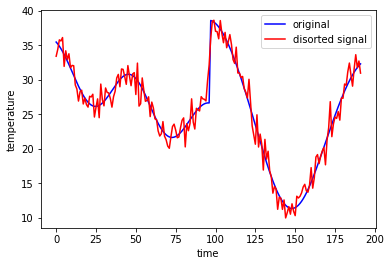

In [5]:
#visualization of x[n] and y[n]
n=np.arange(0,192)

plt.xlabel("time")
plt.ylabel("temperature")
plt.plot(n, x[n], color ="blue")
plt.plot(n, y[n], color ="red")
plt.legend(['original','disorted signal'])
plt.show()

In [6]:
#denoise function
def denoise(signal , kernel_size):
  #signal       :signal to be denoised
  #kernel_size  :the size of kernel used to denoised

  kernel= np.empty(kernel_size, dtype=float)
  kernel.fill(1)
  kernel=kernel/kernel_size
  #kernel will be[0.33, 0.33, 0.33] for size 3 ; [0.2, 0.2, 0.2, 0.2, 0.2] for size 5

  pad_size= kernel_size//2
  padded_signal= np.zeros( 193+ 2*pad_size, dtype=float)
  for i in range(pad_size):
    padded_signal[i]= signal[0]
    padded_signal[-1-i]= signal[192]
  for i in range(193):
    padded_signal[pad_size+ i]= signal[i]


  denoised_signal= np.empty(193, dtype=float)
  for i in range(193):
    denoised_signal[i]= np.dot(padded_signal[i: i+ kernel_size], kernel)
  return denoised_signal
  


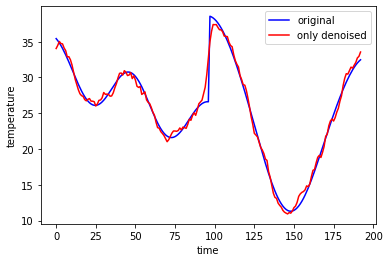

In [7]:
denoised= denoise(y, 5)
n=np.arange(0,193)

plt.xlabel("time")
plt.ylabel("temperature")
plt.plot(n, x[n], color ="blue")
plt.plot(n, denoised, color ="red")
plt.legend(['original','only denoised'])
plt.show()

In [8]:
#DFT OF SIGNAL
j=np.complex(0,1)
def DFT_y(signal):
  F_signal=np.zeros(193, dtype=complex)    
  dw= 2*np.pi/193  
  for k in range(193):    #to variate omegas
    w= dw*k               #after getting our omega, we calculate Y(e^jw) for that omega
    F_i=0                 #Y(e^jw) for that omega is stored in F_i
    for i in range(193):  #Y(e^jw)= summation( y[n]*e^(jwn) where n goes from -inf to +inf
      F_i= F_i + signal[i]*np.exp(-1*j*w*i)
    F_signal[k]=F_i 
  return F_signal

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


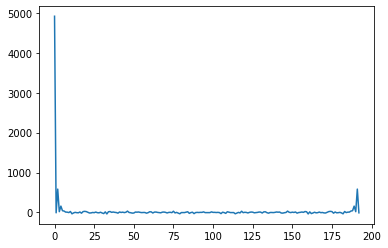

In [9]:

plt.plot(DFT_y(y))

In [10]:
#DFT OF H
#same as DFT_y

def DFT_h(signal):
  F_signal= np.zeros(193, dtype=complex)
  dw=2*np.pi/193
  for k in range(193):   
    w=dw*k
    F_i=0
    for i in range(5):
      F_i= F_i + signal[i]*np.exp(-1*j*w*(i-2))
    F_signal[k]=F_i
  return F_signal


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


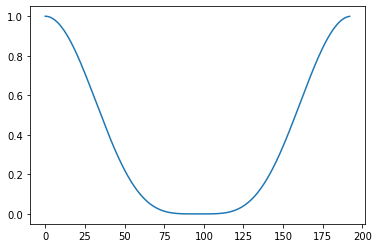

In [11]:
plt.plot(DFT_h(h))

In [12]:
#since x[n]= summation( F(x)*e^(2pi*j*x*n/N))from n=0 to N-1

def inv_ft(ft): #ft corresponds to array of F(x) for different values of x. and the rest is obvious
  signal=np.zeros(193, dtype=complex)
  for i in range(193):
    f=0
    for k in range(193):
      w=2*np.pi*k/193
      f=f+ ft[k]*np.exp(j*i*w)
    signal[i]=f/193
  return signal

In [13]:
#returns an array of Y(e^jw)/H(e^jw) values for different values of omega

def deblur(F_signal, F_h):  
  #F_signal    :list of dft of signal to be deblurred for different values of omega
  #F_h         :list of dft of h, for different values of omega
  F= np.zeros(193, dtype= complex)
  for i in range(193):
    if abs(F_h[i]<0.35):
      F[i]= F_signal[i]/0.35
    else:
      F[i]=F_signal[i]/F_h[i]
  return F




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


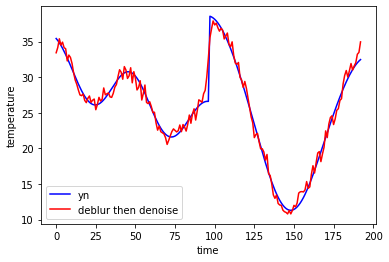

0.9742072885799804


In [14]:
ft=deblur(DFT_y(y), DFT_h(h))   #ft       :an array of Y(e^jw)/H(e^jw) values for different values of omega, where Y(e^jw) is fourier transform of y without denoising
signal= inv_ft(ft)              #signal   :inverse fourier of ft
signal=denoise(signal,5)        #deblurred signal is then denoised

plt.xlabel("time")
plt.ylabel("temperature")
plt.plot(n, x[n], color ="blue")
plt.plot(n, signal[n], color ="red")
plt.legend(['yn','deblur then denoise'])
plt.show()

mse=0
for i in range(193):
  mse=mse+ (x[i]- signal[i])**2
mse=mse/193
print(mse)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


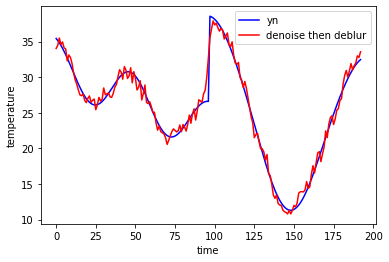

(0.9267337063159031-2.4426004050086887e-13j)


In [15]:
ft=deblur(DFT_y(denoise(y, 5)), DFT_h(h))   #ft     :an array of Y(e^jw)/H(e^jw) values for different values of omega, where Y(e^jw) is fourier transform of y after denoising
signal= inv_ft(ft)                          #signal :inverse fourier of ft

plt.xlabel("time")
plt.ylabel("temperature")
plt.plot(n, x[n], color ="blue")
plt.plot(n, signal[n], color ="red")
plt.legend(['yn','denoise then deblur'])
plt.show()

mse=0
for i in range(193):
  mse=mse+ (x[i]- signal[i])**2
mse=mse/193
print(mse)
